In [40]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configurações
plt.rcParams["figure.figsize"] = (12, 6)

In [41]:
#Carrega dataset

df = pd.read_csv("data/processed/dataset_clean.csv")

# Agrupa por semana (média dos municípios)
df_grouped = df.groupby(["year", "week"], as_index=False)["casos"].mean()

# Cria coluna de data a partir de ano e semana
from datetime import datetime
df_grouped["data"] = df_grouped.apply(
    lambda row: datetime.fromisocalendar(int(row["year"]), int(row["week"]), 1),
    axis=1
)

# Recria série temporal com frequência semanal regular
ts = df_grouped.set_index("data")["casos"]
ts = ts.resample("W-MON").mean()
ts = ts.interpolate(method="linear").ffill().bfill()

In [43]:
#Funções de avaliação
def evaluate(y_true, y_pred, label="Modelo"):
    df_eval = pd.DataFrame({"y_true": y_true, "y_pred": y_pred}).dropna()
    mae = mean_absolute_error(df_eval["y_true"], df_eval["y_pred"])
    rmse = np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_pred"]))
    mape = np.mean(np.abs((df_eval["y_true"] - df_eval["y_pred"]) / df_eval["y_true"])) * 100
    print(f"{label} → MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}%")
    return df_eval

Naïve → MAE: 0.0035 | RMSE: 0.0062 | MAPE: inf%


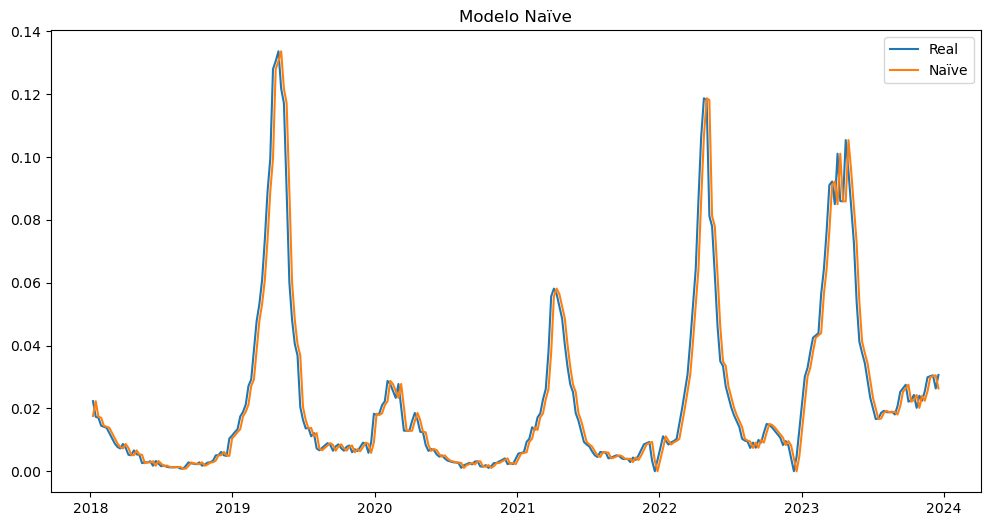

In [44]:
#persistência

y_pred_naive = ts.shift(1)
df_naive = evaluate(ts, y_pred_naive, "Naïve")

plt.plot(df_naive["y_true"], label="Real")
plt.plot(df_naive["y_pred"], label="Naïve")
plt.title("Modelo Naïve")
plt.legend()
plt.show()

Média Móvel → MAE: 0.0071 | RMSE: 0.0123 | MAPE: inf%


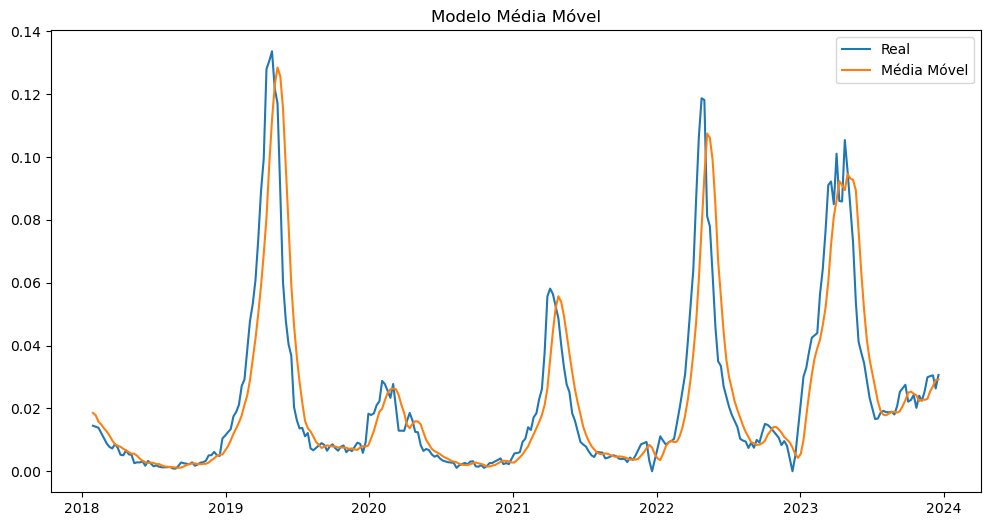

In [45]:
#Média móvel

y_pred_ma = ts.rolling(window=4).mean().shift(1)
df_ma = evaluate(ts, y_pred_ma, "Média Móvel")

plt.plot(df_ma["y_true"], label="Real")
plt.plot(df_ma["y_pred"], label="Média Móvel")
plt.title("Modelo Média Móvel")
plt.legend()
plt.show()

ARIMA → MAE: 0.0030 | RMSE: 0.0052 | MAPE: inf%


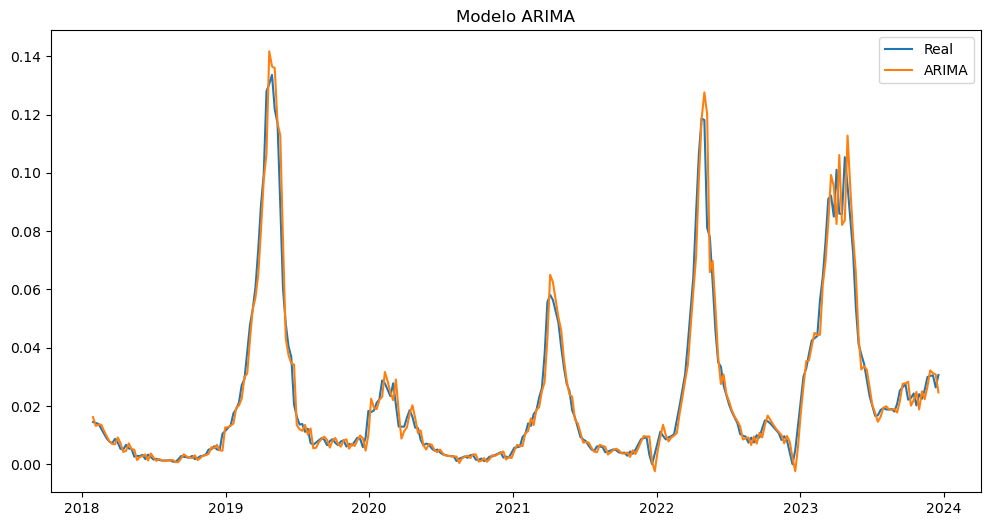

In [46]:
#ARIMA (p,d,q)

model_arima = ARIMA(ts, order=(2, 1, 2))
results_arima = model_arima.fit()
y_pred_arima = results_arima.predict(start=ts.index[4], end=ts.index[-1], typ="levels")
df_arima = evaluate(ts[4:], y_pred_arima, "ARIMA")

plt.plot(df_arima["y_true"], label="Real")
plt.plot(df_arima["y_pred"], label="ARIMA")
plt.title("Modelo ARIMA")
plt.legend()
plt.show()

SARIMA → MAE: 0.0038 | RMSE: 0.0062 | MAPE: inf%


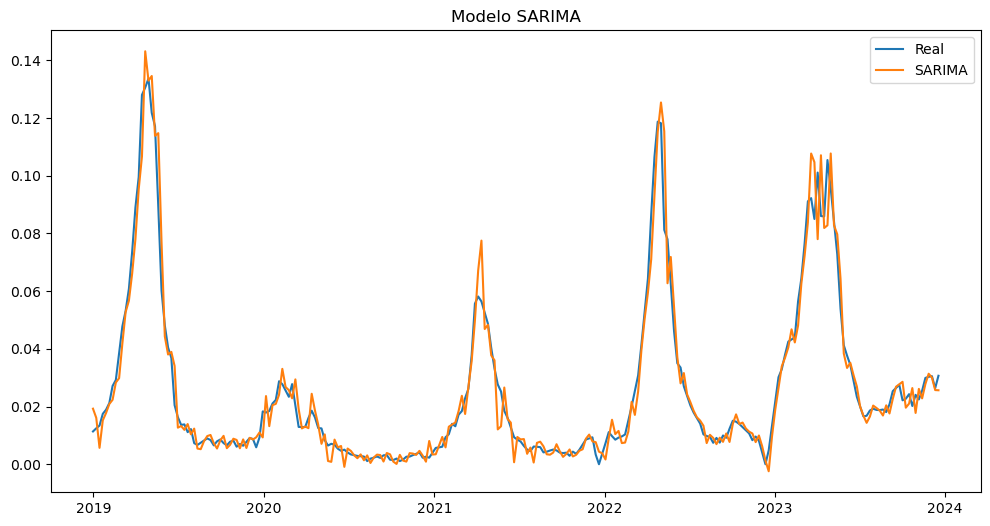

In [48]:
#SARIMA (p,d,q)(P,D,Q,s)
model_sarima = SARIMAX(ts, order=(2, 1, 2), seasonal_order=(1, 1, 1, 52))
results_sarima = model_sarima.fit(disp=False)
y_pred_sarima = results_sarima.predict(start=ts.index[52], end=ts.index[-1])
df_sarima = evaluate(ts[52:], y_pred_sarima, "SARIMA")

plt.plot(df_sarima["y_true"], label="Real")
plt.plot(df_sarima["y_pred"], label="SARIMA")
plt.title("Modelo SARIMA")
plt.legend()
plt.show()

In [49]:
#Métricas calculadas
#MAE: erro absoluto médio
#RMSE: raiz do erro quadrático médio
#MAPE: erro percentual médio absoluto

#Saídas geradas
#Gráficos comparativos entre real e previsto
#Avaliação dos modelos Naïve, Média Móvel, ARIMA e SARIMA
